In [8]:
import pandas as pd
import pandas_datareader.data as reader
from pandas_datareader import wb
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS


In [9]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [10]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [11]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

<AxesSubplot: >

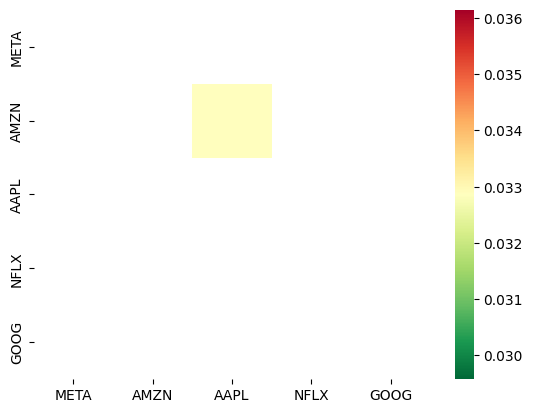

In [12]:
sns.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

In [13]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

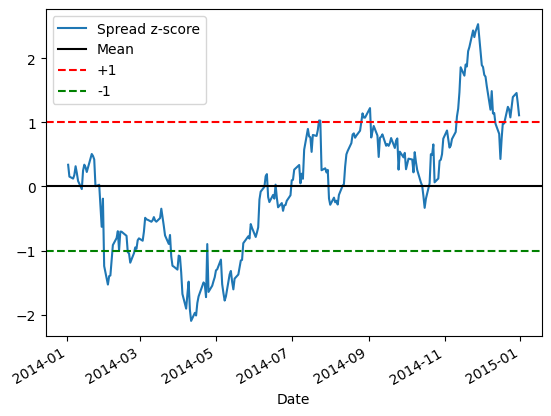

In [14]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

<AxesSubplot: xlabel='Date'>

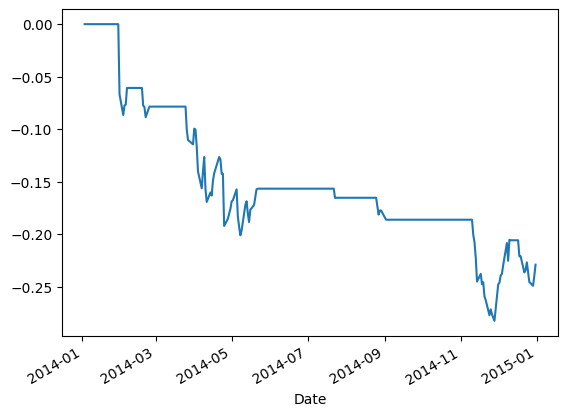

In [16]:
# Create a DataFrame with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1


returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()